In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.filters.hp_filter import hpfilter


In [21]:
# Define the file path
file_path = r"C:\Users\IRLXB03\Desktop\Banking\wrds\data"
# Read the CSV file adding "\output\rcon_balanced.csv" to the file path
df = pd.read_csv(file_path + r"\output\rcon_balanced.csv")
# Read the CSV file adding "\raw\fed_funds_rate.csv" to the file path
df_ffr = pd.read_csv(file_path + r"\raw\fed_funds_rate.csv")
# Read the CSV file adding "\raw\cpi_index" to the file path
df_cpi = pd.read_csv(file_path + r"\raw\cpi_index.csv")
# Read the CSV file adding "\raw\nominal_gdp.csv" to the file path
df_gdp = pd.read_csv(file_path + r"\raw\nominal_gdp.csv")

### Main data frame: Remove flagged observations

In [22]:
# Find the IDs with flag = 1
ids_to_drop = df.loc[df['flag'] == 1, 'IDRSSD'].unique()
# Filter out rows with those IDs
filtered_df = df[~df['IDRSSD'].isin(ids_to_drop)]

In [23]:
# For each moment in time, add RCON2122 across IDRSSD:
df['TOTAL LOANS'] = df.groupby(['DATE'])['RCON2122'].transform('sum')
df = df[['DATE', 'TOTAL LOANS']]
df['DATE'] = pd.to_datetime(df['DATE'])
df = df[['DATE', 'TOTAL LOANS']]
df = df.drop_duplicates()

In [24]:
#what is the minimum date in the dataset?
min_date = df['DATE'].min()
max_date = df['DATE'].max()

### Add FFR: Make dates consistent first

In [25]:
# Data as date time for df_ffr:
df_ffr['DATE'] = pd.to_datetime(df_ffr['DATE'], format='%Y-%m-%d')
# Substract one day from the date:
df_ffr['DATE'] = df_ffr['DATE'] - pd.DateOffset(days=1)
# Drop everything before min_date and after max_date:
df_ffr = df_ffr[(df_ffr['DATE'] >= min_date) & (df_ffr['DATE'] <= max_date)]
# Make FFR float:
df_ffr['FEDFUNDS'] = df_ffr['FEDFUNDS'].astype(float)

### Add CPI: Take to real first (1984-03-31=100)

In [26]:
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'], format='%Y-%m-%d')
# Substract one day from the date:
df_cpi['DATE'] = df_cpi['DATE'] - pd.DateOffset(days=1)
# Rename: CPIAUCSL_NBD19840101
df_cpi.rename(columns={'CPIAUCSL_NBD19840101': 'CPI'}, inplace=True)
# Drop everything before min_date and after max_date
df_cpi = df_cpi[(df_cpi['DATE'] >= min_date) & (df_cpi['DATE'] <= max_date)]
# Make CPi float:
df_cpi['CPI'] = df_cpi['CPI'].astype(float)

### Add Nominal Gdp


In [27]:
df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'], format='%Y-%m-%d')
# Substract one day from the date:
df_gdp['DATE'] = df_gdp['DATE'] - pd.DateOffset(days=1)
# Rename: NGDPSAXDCUSQ
df_gdp.rename(columns={'NGDPSAXDCUSQ': 'GDP'}, inplace=True)
# Drop everything before min_date and after max_date
df_gdp = df_gdp[(df_gdp['DATE'] >= min_date) & (df_gdp['DATE'] <= max_date)]
# Make GDP float:
df_gdp['GDP'] = df_gdp['GDP'].astype(float)

### Merge all datasets, by date:

In [28]:
# Merge all datasets by date:
df = df.merge(df_ffr, on='DATE', how='left')
df = df.merge(df_cpi, on='DATE', how='left')
df = df.merge(df_gdp, on='DATE', how='left')

In [29]:
# Divide TOTAL LOANS by CPI to get REAL LOANS:
df['REAL LOANS'] = (df['TOTAL LOANS'] / df['CPI']) * 100
# Divide GDP by CPI to get REAL GDP:
df['REAL GDP'] = (df['GDP'] / df['CPI'])  * 100
# Define Log of REAL LOANS:
df['LOG REAL LOANS'] = np.log(df['REAL LOANS'])
# Define Log of REAL GDP:
df['LOG REAL GDP'] = np.log(df['REAL GDP'])

In [30]:
# Show all rows:
pd.set_option('display.max_rows', None)

# Order everything by date:
df = df.sort_values(by='DATE')

In [31]:
lambda_quarterly = 1000000000
df['LOANS_CYCLE'], df['LOANS_TREND'] = hpfilter(df['LOG REAL LOANS'], lamb=lambda_quarterly)
df['GDP_CYCLE'], df['GDP_TREND'] = hpfilter(df['LOG REAL GDP'], lamb=lambda_quarterly)


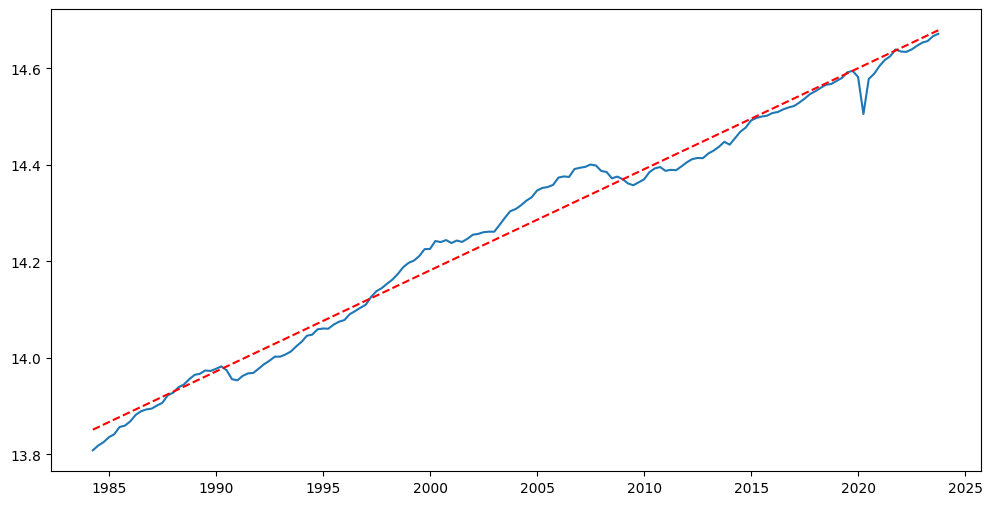

In [32]:
# plot GDP:
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['LOG REAL GDP'], label='ln')
plt.plot(df['DATE'], df['GDP_TREND'], label='Trend', color='red', linestyle='--')

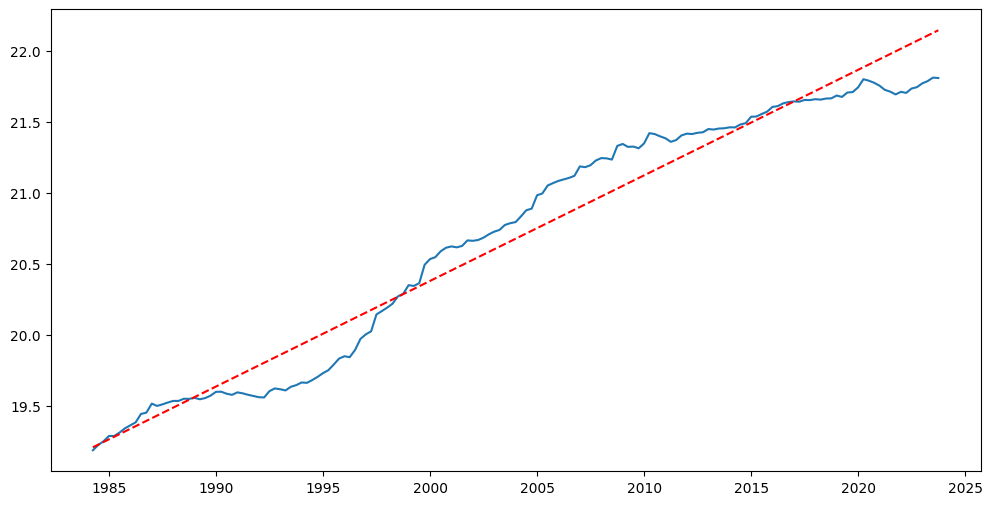

In [33]:
# plot Loans:
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['LOG REAL LOANS'], label='ln')
plt.plot(df['DATE'], df['LOANS_TREND'], label='Trend', color='red', linestyle='--')

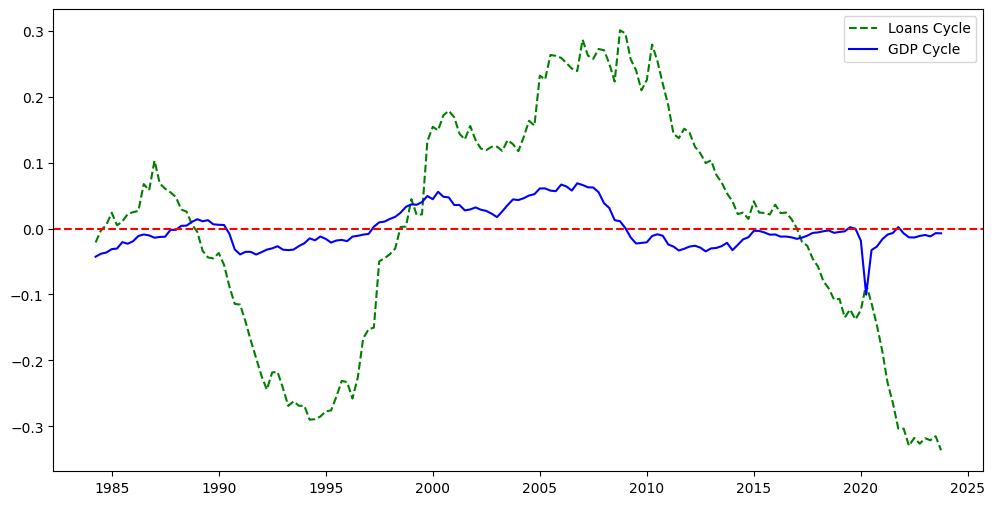

In [41]:
# Plot cycle for gdp and loans:
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['LOANS_CYCLE'], label='Loans Cycle', color='green', linestyle='--')
plt.plot(df['DATE'], df['GDP_CYCLE'], label='GDP Cycle', color='blue')
# zero line:
plt.axhline(y=0, color='red', linestyle='--')
# Add legend:
plt.legend()
# Show the plot:
plt.show()

In [35]:
# Correlation for GDP and Loans cycle:
correlation = df['LOANS_CYCLE'].corr(df['GDP_CYCLE'])
print(correlation)

0.5288502736916083


In [36]:
# Standarized FEDFUNDS:
df['STANDARDIZED FEDFUNDS'] = (df['FEDFUNDS'] - df['FEDFUNDS'].mean()) / df['FEDFUNDS'].std()

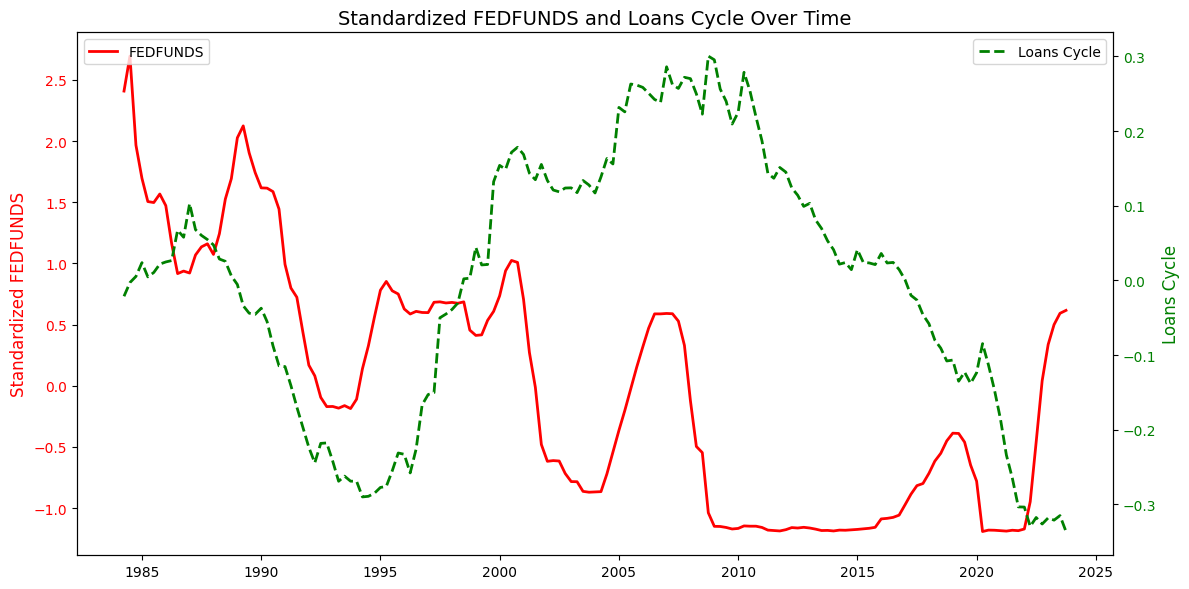

In [40]:
# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a second y-axis
ax2 = ax1.twinx()

# Plot on the first y-axis
ax1.plot(df['DATE'], df['STANDARDIZED FEDFUNDS'], label='FEDFUNDS', color='red', linewidth=2)
ax1.set_ylabel('Standardized FEDFUNDS', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')

# Plot on the second y-axis
ax2.plot(df['DATE'], df['LOANS_CYCLE'], label='Loans Cycle', color='green', linewidth=2, linestyle='--')
ax2.set_ylabel('Loans Cycle', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both lines
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title and x-axis label
plt.title('Standardized FEDFUNDS and Loans Cycle Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [42]:
# correlation about FEDFUNDS and Loans cycle:
correlation = df['LOANS_CYCLE'].corr(df['STANDARDIZED FEDFUNDS'])
print(correlation)

-0.15044986576423025
